In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gpflow
from gpflow.utilities import print_summary, positive
plt.style.use('ggplot')
%matplotlib inline
import tensorflow as tf
import math
from tensorflow import math as tm
from sklearn import preprocessing
from scipy.interpolate import interp1d

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow_probability import mcmc

PI = tf.constant(math.pi, dtype='float64')

In [2]:
# np.set_printoptions(threshold=np.inf)
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
# k_exp.D[2] = 1.2849
# k_exp.D[3] = 1.0959
# k_exp.lengthscale.assign(1.4110)
# k_exp.h(2, 3).numpy()


# Replication of the paper by Lawrence et al., 2006

https://papers.nips.cc/paper/3119-modelling-transcriptional-regulation-using-gaussian-processes.pdf

#### Probesets

The original paper restricted their interest to 5 known targets of p53: 
- DDB2 -------------- (probeset 203409_at)
- p21 ----------------- (probeset 202284_s_at) (alias p21CIP1, CDKN1A)
- SESN1/hPA26 -- (probeset 218346_s_at)
- BIK ----------------- (probeset 205780_at)
- TNFRSF10b ----- (probeset 209294_x_at, 209295_at, 210405_x_at)

In [74]:
mmgmos_processed = True
if mmgmos_processed:
    with open('barencoPUMA_exprs.csv', 'r') as f:
        df = pd.read_csv(f, index_col=0)
    with open('barencoPUMA_se.csv', 'r') as f:
        dfe = pd.read_csv(f, index_col=0)
    columns = [f'cARP1-{t}hrs.CEL' for t in np.arange(7)*2]

else:
    with open('barenco_processed.tsv', 'r') as f:
        df = pd.read_csv(f, delimiter='\t', index_col=0)
    display(df.head(5))
    columns = [f'H_ARP1-{t}h.3' for t in np.arange(7)*2]

known_target_genes = ['203409_at', '202284_s_at', '218346_s_at', '205780_at', '209295_at']
genes = df[df.index.isin(known_target_genes)][columns]
genes_se = dfe[dfe.index.isin(known_target_genes)][columns]


In [75]:
assert df[df.duplicated()].size == 0

### Probeset Combination

TNFRSF10b has multiple probesets (probeset 209294_x_at, 209295_at, 210405_x_at) which should be combined.

It can be observed below that the log intensities have a similar pattern. Thus a popular way to combine is to take the average of the log intensities.

In [76]:
COMBINE_MULTIPLE_PROBESETS = False
if COMBINE_MULTIPLE_PROBESETS:
    plt.figure(figsize=(10,7))
    plt.subplot(2,2,1)
    p53 = df[df.index.isin(['211300_s_at', '201746_at'])][columns].astype(float)
    for index, row in p53.iterrows():
        p53.loc[index] = np.log(list(row))
        plt.plot(list(row))

    p53_mean = pd.Series(p53.mean(0), index=genes.columns, name='p53')

    plt.subplot(2,2,2)
    TNFRSF10b = df[df.index.isin(['209294_x_at', '209295_at', '210405_x_at'])][columns]
    for index, row in TNFRSF10b.iterrows():
        print(list(row))
        TNFRSF10b.loc[index] = np.log(list(row))
        plt.plot(list(row))

    TNFRSF10b_mean = pd.Series(TNFRSF10b.mean(0), index=genes.columns, name='TNFRSF10b')
    
    plt.figure()
    plt.plot(p53_mean)

In [77]:
index ={
    '203409_at': 'DDB2', 
    '202284_s_at': 'p21',
    '218346_s_at': 'SESN1',
    '205780_at': 'BIK',
    '209295_at': 'TNFRSF10b'
}
genes.rename(index=index, inplace=True)
genes_se.rename(index=index, inplace=True)

# genes = genes.append(TNFRSF10b_mean, ignore_index=False)
# genes = genes.append(p53_mean, ignore_index=False).astype(np.float64)

genes = genes.reindex(['DDB2', 'SESN1', 'TNFRSF10b', 'p21', 'BIK'])
genes_se = genes_se.reindex(['DDB2', 'SESN1', 'TNFRSF10b', 'p21', 'BIK'])
display(genes)
display(genes_se)


,cARP1-0hrs.CEL,cARP1-2hrs.CEL,cARP1-4hrs.CEL,cARP1-6hrs.CEL,cARP1-8hrs.CEL,cARP1-10hrs.CEL,cARP1-12hrs.CEL
DDB2,7.593549,9.122439,10.192915,10.154778,10.103455,9.529804,9.567770
SESN1,6.354029,7.703226,8.818485,8.608104,8.803210,7.860224,7.981910
TNFRSF10b,3.949437,7.283147,8.395333,8.147465,8.456766,7.370946,7.409659
p21,1.268160,7.375613,9.600847,8.485615,8.134573,7.045323,7.171770
BIK,2.905667,6.756250,8.154665,8.222898,8.074595,7.026262,7.001658


,cARP1-0hrs.CEL,cARP1-2hrs.CEL,cARP1-4hrs.CEL,cARP1-6hrs.CEL,cARP1-8hrs.CEL,cARP1-10hrs.CEL,cARP1-12hrs.CEL
DDB2,0.249263,0.137954,0.092652,0.092837,0.095946,0.117834,0.111057
SESN1,0.322529,0.185634,0.117371,0.124440,0.117990,0.170974,0.155030
TNFRSF10b,0.939674,0.230524,0.146372,0.156875,0.140932,0.222533,0.209342
p21,2.587364,0.557080,0.216786,0.326715,0.392748,0.624041,0.566781
BIK,1.835773,0.605828,0.346498,0.308507,0.331839,0.524867,0.503841


### Setup data

In [78]:
num_genes = 5 #X.shape[1]
num_times = 7
scaler = preprocessing.StandardScaler()
training_genes = genes.values
training_genes_se = genes_se.values


Y_var = training_genes_se*training_genes_se
Y = np.exp(training_genes+Y_var/2)
Y_var = (np.exp(Y_var)-1) * np.exp(2*training_genes + Y_var)

scale = np.sqrt(np.var(Y, axis=1));
scale_mat = np.c_[[scale for _ in range(7)]].T
Y = Y / scale_mat
Y_var = Y_var / (scale_mat * scale_mat)

Y_orig_shape = Y.shape
Y = Y.reshape(-1, 1)
Y_var = Y_var.reshape(-1, 1)
Sigma = tf.linalg.tensor_diag(Y_var.reshape(-1))

X = np.arange(num_times, dtype='float64')*2
X = np.c_[[X for _ in range(num_genes)]].reshape(-1)
print(X)
print(Y[:8])
print(X.shape,Y.shape)

[ 0.  2.  4.  6.  8. 10. 12.  0.  2.  4.  6.  8. 10. 12.  0.  2.  4.  6.
  8. 10. 12.  0.  2.  4.  6.  8. 10. 12.  0.  2.  4.  6.  8. 10. 12.]
[[0.23514879]
 [1.06162693]
 [3.0803851 ]
 [2.96517215]
 [2.8176567 ]
 [1.59136875]
 [1.65166642]
 [0.27094984]]
(35,) (35, 1)


### Model

We fix the sensitivity of p21 to be 1, and decay to be 0.8 as in Barenco et al.

            K_xx = np.zeros([X.shape[0],X.shape[0]], dtype='float64')
            print(K_xx.shape)
            for j in range(num_genes):
                for k in range(num_genes):
                    K_xx[j*block_size:(j+1)*block_size, 
                         k*block_size:(k+1)*block_size] = self.k_xx(j, k, X)
            return K_xx


In [210]:
class ExpressionKernel(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(active_dims=[0])
        self.lengthscale = gpflow.Parameter(1.0, transform=positive())
#         B = tf.ones(5)
#         self.B = gpflow.Parameter(B)
#         self.D = gpflow.Parameter(np.random.uniform(0.5, 1, 5), transform=positive())
#         S = tf.ones(5)
        D_affine = tfb.AffineScalar(shift=tf.cast(0.1, tf.float64),
                                    scale=tf.cast(1.5-0.1, tf.float64))
        D_sigmoid = tfb.Sigmoid()
        D_logistic = tfb.Chain([D_affine, D_sigmoid])
        S_affine = tfb.AffineScalar(shift=tf.cast(0.1, tf.float64),
                                    scale=tf.cast(3.-0.1, tf.float64))
        S_sigmoid = tfb.Sigmoid()
        S_logistic = tfb.Chain([S_affine, S_sigmoid])

        self.D = [gpflow.Parameter(np.random.uniform(1, 1), transform=S_logistic, dtype=tf.float64) for _ in range(num_genes)]
        self.D[3].trainable = False
        self.D[3].assign(0.8)

        self.S = [gpflow.Parameter(np.random.uniform(1, 1), transform=S_logistic, dtype=tf.float64) for _ in range(num_genes)]
        self.S[3].trainable = False
        self.S[3].assign(1)
        
        
    def K(self, X, X2=None):
        self.block_size = int(X.shape[0]/num_genes)
        interp = interp1d(np.arange(Y_var.shape[0]), Y_var.reshape(-1), kind='linear')
        Sigma = interp(np.linspace(0,Y_var.shape[0]-1, X.shape[0]))
        Sigma = tf.linalg.tensor_diag(Sigma)
        if X2 is None:
            shape = [X.shape[0],X.shape[0]]
            K_xx = tf.zeros(shape, dtype='float64')
            for j in range(num_genes):
                for k in range(num_genes):
                    mask = np.ones(shape)
                    other = np.zeros(shape)
                    mask[j*self.block_size:(j+1)*self.block_size, 
                         k*self.block_size:(k+1)*self.block_size] = 0
                    
                    pad_top = j*self.block_size
                    pad_left = k*self.block_size
                    pad_right = 0 if k == num_genes-1 else shape[0]-self.block_size-pad_left
                    pad_bottom = 0 if j == num_genes-1 else shape[0]-self.block_size-pad_top
                    other = tf.pad(self.k_xx(j, k),
                                   tf.constant([
                                       [pad_top,pad_bottom],
                                       [pad_left,pad_right]
                                   ]), 'CONSTANT'
                                  )
#                     print(j, k, pad_right, pad_bottom, other.shape)
                    K_xx = K_xx * mask + other * (1 - mask)


            return K_xx + Sigma
        else:
            '''Calculate K_xf: no need to use tf.* since this part is not optimised'''
            print('K not none K_xf\n')
            shape = [X.shape[0],X2.shape[0]]#self.block_size]

            K_xf = np.zeros(shape, dtype='float64')
            for j in range(num_genes):
                print('putting', K_xf[j*self.block_size:(j+1)*self.block_size].shape)
                K_xf[j*self.block_size:(j+1)*self.block_size] = self.k_xf(j, X, X2)
            return K_xf
        
    def k_xf(self, j, X, X2):
        t_prime, t_, t_dist = self.get_distance_matrix(t_x=X[:self.block_size], 
                                                       t_y=X2)
        l = self.lengthscale
        erf_term = tm.erf(t_dist/l - self.gamma(j)) + tm.erf(t_/l + self.gamma(j))
        
        return self.S[j]*l*0.5*tm.sqrt(PI)*tm.exp(self.gamma(j))**2 *tm.exp(-self.D[j]*t_dist)*erf_term

    def gamma(self, k):
        return self.D[k]*self.lengthscale/2

    def h(self, k, j, primefirst=True):
        l = self.lengthscale
#         print(l, self.D[k], self.D[j])
        t_prime, t, t_dist = self.get_distance_matrix(primefirst=primefirst, size=self.block_size)
        multiplier = tm.exp(self.gamma(k)**2) / (self.D[j]+self.D[k])
        first_erf_term = tm.erf(t_dist/l - self.gamma(k)) + tm.erf(t/l + self.gamma(k))
        second_erf_term = tm.erf(t_prime/l - self.gamma(k)) + tm.erf(self.gamma(k))
        return multiplier * (tf.multiply(tm.exp(-tm.multiply(self.D[k],t_dist)) , first_erf_term) - \
                             tf.multiply(tm.exp(-tm.multiply(self.D[k],t_prime)-tm.multiply(self.D[j],t)) , second_erf_term))
    

    def k_xx(self, j, k):
        '''k_xx(t, tprime)'''
        mult = self.S[j]*self.S[k]*self.lengthscale*0.5*tm.sqrt(PI)
        return mult*(self.h(k, j) + self.h(j, k, primefirst=False))


    def get_distance_matrix(self, primefirst=True, size=None, t_x=None, t_y=None):
        if size is not None:
            t = tf.cast(tf.range(size)*2, tf.float64)
            t_ = tf.reshape(tf.tile(t, [size]), [ size, tf.shape(t)[0]])
            t_prime = tf.transpose(tf.reshape(tf.tile(t, [size]), [ size, tf.shape(t)[0]]))
            if not primefirst:
                t_prime = tf.reshape(tf.tile(t, [size]), [ size, tf.shape(t)[0]])
                t_ = tf.transpose(tf.reshape(tf.tile(t, [size]), [ size, tf.shape(t)[0]]))

            return t_prime, t_, t_prime-t_
        else:
            t_1 = np.reshape(np.tile(t_x, t_y.shape[0]), [ t_y.shape[0], t_x.shape[0]]).T
            t_2 = np.reshape(np.tile(t_y, t_x.shape[0]), [ t_x.shape[0], t_y.shape[0]])
#             print(t_1, t_2, t_1-t_2)
            return t_1, t_2, t_1-t_2
    
    def K_diag(self, X):
        print('k_diag')

        """I've used the fact that we call this method for K_ff when finding the covariance as a hack so
        I know if I should return K_ff or K_xx. In this case we're returning K_ff!!
        $K_{ff}^{post} = K_{ff} - K_{fx} K_{xx}^{-1} K_{xf}$"""
        _,_,t_dist = self.get_distance_matrix(size=X.shape[0])
        K_ff = tf.math.exp(-(t_dist**2)/(self.lengthscale**2))
        return tf.linalg.tensor_diag_part(K_ff)


k_exp = ExpressionKernel()
print_summary(k_exp, fmt='notebook')



name,class,transform,trainable,prior,shape,dtype
ExpressionKernel.lengthscale,Parameter,Softplus,True,(),float64,1
ExpressionKernel.D[0],Parameter,Chain,True,(),float64,1
ExpressionKernel.D[1],Parameter,Chain,True,(),float64,1
ExpressionKernel.D[2],Parameter,Chain,True,(),float64,1
ExpressionKernel.D[3],Parameter,Chain,False,(),float64,0.8
ExpressionKernel.D[4],Parameter,Chain,True,(),float64,1
ExpressionKernel.S[0],Parameter,Chain,True,(),float64,1
ExpressionKernel.S[1],Parameter,Chain,True,(),float64,1
ExpressionKernel.S[2],Parameter,Chain,True,(),float64,1
ExpressionKernel.S[3],Parameter,Chain,False,(),float64,1


In [211]:
class MeanFunction(gpflow.mean_functions.MeanFunction):
    def __init__(self):
        affine = tfb.AffineScalar(shift=tf.cast(0., tf.float64),
                                  scale=tf.cast(2.-0., tf.float64))
        sigmoid = tfb.Sigmoid()
        logistic = tfb.Chain([affine, sigmoid])

        self.B = [gpflow.Parameter(np.mean(row)*k_exp.D[i], transform=logistic) for i, row in enumerate(Y.reshape(Y_orig_shape))]

    def __call__(self, X):
        ret = tf.zeros(0, dtype='double')
        block_size = int(X.shape[0]/num_genes)
        for j in range(num_genes):
            ret = tf.concat([ret, tf.repeat(self.B[j]/k_exp.D[j], block_size)], axis=0)
#         ret = tf.divide(self.B, (k_exp.D)).repeat(7)

        return ret

meanfunc_exp = MeanFunction()

In [212]:
model = gpflow.models.GPR(data=(X, Y), kernel=k_exp, mean_function=meanfunc_exp)
gpflow.config.set_default_jitter(1e3)

opt = gpflow.optimizers.Scipy()
print_summary(model)
Ds = list()

@tf.function
def objective_closure():
#     global Ds
    try:
        ret = - model.log_marginal_likelihood()
    except:
        print_summary(model)
        raise Exception('Failed (probably Cholesky decomposition)')


#     Ds.append([s.numpy() for s in model.kernel.D])

    tf.print(ret)
    return ret
opt_logs = opt.minimize(objective_closure,
                        model.trainable_variables,
                        options=dict(maxiter=40, disp=True),
                        method='CG')
print_summary(model)


name                     class      transform    trainable    prior    shape       dtype
-----------------------  ---------  -----------  -----------  -------  -------  --------
GPR.mean_function.B[0]   Parameter  Chain        True         ()       float64  1.91472
GPR.mean_function.B[1]   Parameter  Chain        True         ()       float64  1.75657
GPR.mean_function.B[2]   Parameter  Chain        True         ()       float64  1.55876
GPR.mean_function.B[3]   Parameter  Chain        True         ()       float64  0.693632
GPR.mean_function.B[4]   Parameter  Chain        True         ()       float64  1.48108
GPR.kernel.lengthscale   Parameter  Softplus     True         ()       float64  1
GPR.kernel.D[0]          Parameter  Chain        True         ()       float64  1
GPR.kernel.D[1]          Parameter  Chain        True         ()       float64  1
GPR.kernel.D[2]          Parameter  Chain        True         ()       float64  1
GPR.kernel.D[3]          Parameter  Chain        Fals

All the Hamiltonian MCMC sampling takes place in an unconstrained space (where constrained parameters have been mapped via a bijector to an unconstrained space). This makes the optimization, as required in the gradient step, much easier.

However, we often wish to sample the constrained parameter values, not the unconstrained one. The SamplingHelper helps us convert our unconstrained values to constrained parameter ones.

In general, adaptation prevents the chain from reaching a stationary distribution, so obtaining consistent samples requires num_adaptation_steps be set to a value somewhat smaller than the number of burnin steps

step_size: Larger step sizes lead to faster progress, but too-large step sizes make rejection exponentially more likely. When possible, it's often helpful to match per-variable step sizes to the standard deviations of the target distribution in each variable

num_leapfrog_steps: Integer number of steps to run the leapfrog integrator for. Total progress per HMC step is roughly proportional to step_size * num_leapfrog_steps.


In [ ]:
get_param_dists = True
f64 = gpflow.utilities.to_default_float

if get_param_dists:
    #https://mc-stan.org/docs/2_22/stan-users-guide/fit-gp-section.html --> priors for length-scale
    model.kernel.lengthscale.prior = tfd.Gamma(f64(1), f64(1))
    model.likelihood.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
    for D in model.kernel.D:
        D.prior = tfd.Gamma(f64(1), f64(1))#tfd.Normal(f64(D.numpy()), f64(0.12))
    for S in model.kernel.S:
        S.prior = tfd.Gamma(f64(1), f64(1))#tfd.Normal(f64(S.numpy()), f64(0.12))
    for B in model.mean_function.B:
        B.prior = tfd.Gamma(f64(1), f64(1))#tfd.Normal(f64(B.numpy()), f64(0.12))
    print_summary(model)

    num_samples = 1000
    num_burnin_steps = 100

    hmc_helper = gpflow.optimizers.SamplingHelper(
        target_log_prob_fn=model.log_marginal_likelihood, 
        model_parameters = model.trainable_parameters
    )

    hmc = mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=hmc_helper.target_log_prob_fn,
        num_leapfrog_steps=5,
        step_size=0.01
    )
    adaptive_hmc = mcmc.SimpleStepSizeAdaptation(
        hmc, #mcmc.TransformedTransitionKernel(, bijectors),
        num_adaptation_steps=int(num_burnin_steps*0.8),
        target_accept_prob=f64(0.75),
        adaptation_rate=0.1
    )
#     adaptive_hmc.bootstrap_results(hmc_helper.current_state)
    
# if False:
    @tf.function
    def run_chain_fn():
#         def trace_fn(something, pkr):
#             print(something)
#             print_summary(model)
#             return pkr.inner_results.is_accepted
        return mcmc.sample_chain(
            num_results=num_samples,
            num_burnin_steps=num_burnin_steps,
            current_state=hmc_helper.current_state,
            kernel=adaptive_hmc,
            trace_fn = lambda _, pkr: pkr.inner_results.is_accepted
        )

    samples, traces = run_chain_fn()
    parameter_samples = hmc_helper.convert_constrained_values(samples)


name                     class      transform    trainable    prior    shape         dtype
-----------------------  ---------  -----------  -----------  -------  -------  ----------
GPR.mean_function.B[0]   Parameter  Chain        True         ()       float64  0.0993754
GPR.mean_function.B[1]   Parameter  Chain        True         ()       float64  0.110365
GPR.mean_function.B[2]   Parameter  Chain        True         ()       float64  0.125254
GPR.mean_function.B[3]   Parameter  Chain        True         ()       float64  0.139805
GPR.mean_function.B[4]   Parameter  Chain        True         ()       float64  0.132161
GPR.kernel.lengthscale   Parameter  Softplus     True         ()       float64  0.272161
GPR.kernel.D[0]          Parameter  Chain        True         ()       float64  0.572958
GPR.kernel.D[1]          Parameter  Chain        True         ()       float64  0.63455
GPR.kernel.D[2]          Parameter  Chain        True         ()       float64  0.701415
GPR.kernel.D[3]  

{'.mean_function.B[0]': 0.01355295678808655, '.mean_function.B[1]': 0.01614241258230781, '.mean_function.B[2]': 0.014835225442467391, '.mean_function.B[3]': 0, '.mean_function.B[4]': 0} [0.005174198222051062, 0.020686604815193053, 0.014610587205436835, 0.05110646412962727, 0.0006961668332033197]


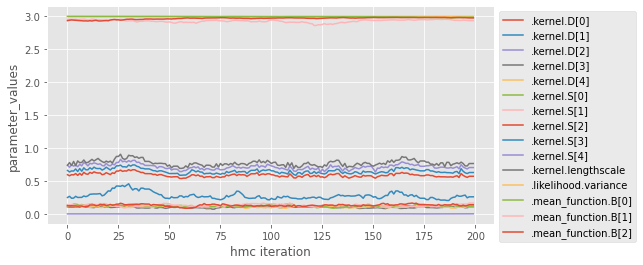

In [84]:
param_to_name = {param: name for name, param in
                 gpflow.utilities.parameter_dict(model).items()}

D_mcmc = {f'.kernel.D[{i}]': 0 for i in range(num_genes)}
S_mcmc = {f'.kernel.S[{i}]':0 for i in range(num_genes)}
B_mcmc = {f'.mean_function.B[{i}]':0 for i in range(num_genes)}
lengthscale = 0

plt.figure(figsize=(8,4))

for val, param in zip(parameter_samples, model.parameters):
    name = param_to_name[param]
    plt.plot(tf.squeeze(val), label=name)

    if 'lengthscale' in name:
        lengthscale = np.std(val)
    elif 'kernel.D' in name:
        D_mcmc[name] = np.std(val)
    elif 'kernel.S' in name:
        S_mcmc[name] = np.std(val)
    elif 'function.B' in name:
        B_mcmc[name] = np.std(val)

plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('hmc iteration')
plt.ylabel('parameter_values');

print(B_mcmc, list(S_mcmc.values()))
# plot_samples(samples, 'unconstrained_variables_values')

c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


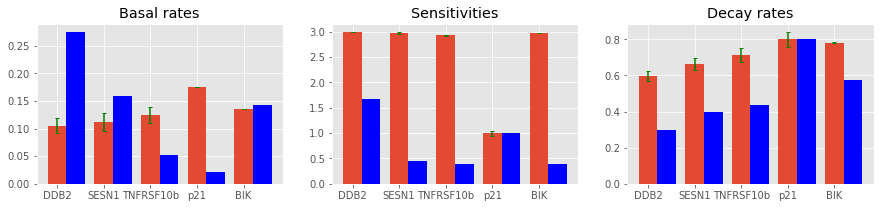

In [85]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 1)
B = [s.numpy() for s in model.mean_function.B]
S = [s.numpy() for s in model.kernel.S]
D = [d.numpy() for d in model.kernel.D]
B_barenco = np.array([2.6, 1.5, 0.5, 0.2, 1.35])# From Martino paper ... but don't know the scale
B_barenco = B_barenco/np.mean(B_barenco)*np.mean(B)# do a rough rescaling so that the scales match.
S_barenco = np.array([3, 0.8, 0.7, 1.8, 0.7])/1.8
D_barenco = np.array([1.2, 1.6, 1.75, 3.2, 2.3])*0.8/3.2


data = [B, S, D]
barenco_data = [B_barenco, S_barenco, D_barenco]
vars = [B_mcmc, S_mcmc, D_mcmc]
labels = ['Basal rates', 'Sensitivities', 'Decay rates']

plotnum = 331
for A, B, var, label in zip(data, barenco_data, vars, labels):
    plt.subplot(plotnum)
    plotnum+=1
    plt.bar(np.arange(5)-0.2, A, width=0.4, tick_label=genes.index[:num_genes])
    plt.bar(np.arange(5)+0.2, B, width=0.4, color='blue', align='center')

    plt.title(label)
    plt.errorbar(np.arange(5)-0.2, A, yerr=list(var.values()), fmt='none', color='green', capsize=2)
# plt.bar(range(5), S, tick_label=genes.index[:num_genes])
# plt.title('')
# plt.errorbar(range(5), S, list(S_mcmc.values()), color='green')

# plt.subplot(3, 3, 3)
# plt.bar(range(5), D, tick_label=genes.index[:num_genes])
# plt.title()

In [205]:
pred_t = np.linspace(0, 12, 100, dtype='float64')

k = model.kernel

K_inv = tf.linalg.inv(k.K(X_data, None))
Kxf = k.K(X_data, pred_t)
print(Kxf.shape, K_inv.shape)
x = tf.convert_to_tensor(Y) - np.repeat(B/np.array(D), 7).reshape(-1, 1)
print(x.shape)
KfxKxx = tf.matmul(tf.transpose(Kxf), K_inv)
mu_post = tf.matmul(KfxKxx, Y) #replace with x?

print(tf.transpose(Kxf).shape, '*', K_inv.shape,'==', KfxKxx.shape, '*', x.shape)
print('mu shape', mu_post.shape)


K not none K_xf

putting (7, 100)
putting (7, 100)
putting (7, 100)
putting (7, 100)
putting (7, 100)
(35, 100) (35, 35)
(35, 1)
(100, 35) * (35, 35) == (100, 35) * (35, 1)
mu shape (100, 1)


(-1.0, 4.0)

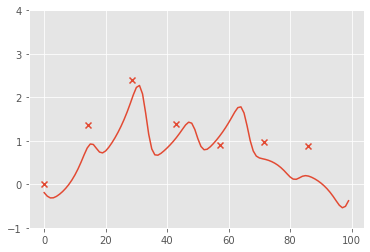

In [206]:
scale_pred = np.sqrt(np.var(mu_post));
barencof = np.array([[0.0, 200.52011, 355.5216125, 205.7574913, 135.0911372, 145.1080997, 130.7046969],
                     [0.0, 184.0994134, 308.47592, 232.1775328, 153.6595161, 85.7272235, 168.0910562],
                     [0.0, 230.2262511, 337.5994811, 276.941654, 164.5044287, 127.8653452, 173.6112139]])


barencof = barencof[0]/(np.sqrt(np.var(barencof[0])))*scale_pred;
measured_p53 = df[df.index.isin(['211300_s_at', '201746_at'])][columns].astype(float)
measured_p53 = measured_p53.mean(0)
measured_p53 = measured_p53*scale_pred

lb = len(barencof)
plt.scatter(np.arange(lb) * 100/lb, barencof, marker='x')
plt.plot(mu_post)
plt.ylim(-1, 4)

# Kff = k.K_diag(X)
# K_post = Kff - KfxKxx * Kxf
# print('K shape', K_post.shape)

In [27]:
mean, var = model.predict_f(X)
mean

k_diag
K not none K_xf

err shape (35, 1)


InvalidArgumentError: Incompatible shapes: [35] vs. [7] [Op:Sub] name: sub/

In [ ]:
plt.subplot(2, 2, 1)
plt.plot(mean)
plt.subplot(2, 2, 2)
plt.plot(genes[genes.index == 'p53'].values[0])

k_diag


<tf.Tensor: shape=(35,), dtype=float64, numpy=
array([1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000,
       1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000,
       1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000,
       1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000])>

## Non-linear response
    